<div style="float:left">
    <h1 style="width:450px">Practical 10: </h1>
    <h2 style="width:450px">Linking &amp; Visualising Data</h2>
</div>
<div style="float:right"><img width="100" src="https://github.com/jreades/i2p/raw/master/img/casa_logo.jpg" /></div>

<div class="alert alert-block alert-warning">
    <b>&#9888; Important</b>: This practical focusses on two key bits of <em>implementation</em>: visualisation and data linkage! You will have seen quite a bit of each of these across the preceding three to four weeks, but they were picked up in an <em>ad-hoc</em> way, here we try to systematise things a bit.</div>

### Required Imports

In [1]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns

import matplotlib.cm as cm
import matplotlib.pyplot as plt

In [2]:
import os
from requests import get
from urllib.parse import urlparse

def cache_data(src:str, dest:str) -> str:
    """Downloads and caches a remote file locally.
    
    The function sits between the 'read' step of a pandas or geopandas
    data frame and downloading the file from a remote location. The idea
    is that it will save it locally so that you don't need to remember to
    do so yourself. Subsequent re-reads of the file will return instantly
    rather than downloading the entire file for a second or n-th itme.
    
    Parameters
    ----------
    src : str
        The remote *source* for the file, any valid URL should work.
    dest : str
        The *destination* location to save the downloaded file.
        
    Returns
    -------
    str
        A string representing the local location of the file.
    """
    
    url = urlparse(src) # We assume that this is some kind of valid URL 
    fn  = os.path.split(url.path)[-1] # Extract the filename
    dfn = os.path.join(dest,fn) # Destination filename
    
    # Check if dest+filename does *not* exist -- 
    # that would mean we have to download it!
    if not os.path.isfile(dfn) or os.path.getsize(dfn) < 1:
        
        print(f"{dfn} not found, downloading!")

        # Convert the path back into a list (without)
        # the filename -- we need to check that directories
        # exist first.
        path = os.path.split(dest)
        
        # Create any missing directories in dest(ination) path
        # -- os.path.join is the reverse of split (as you saw above)
        # but it doesn't work with lists... so I had to google how
        # to use the 'splat' operator! os.makedirs creates missing
        # directories in a path automatically.
        if len(path) >= 1 and path[0] != '':
            os.makedirs(os.path.join(*path), exist_ok=True)
            
        # Download and write the file
        with open(dfn, "wb") as file:
            response = get(src)
            file.write(response.content)
            
        print('Done downloading...')

    else:
        print(f"Found {dfn} locally!")

    return dfn

## Task 1. Spatial Joins (Recap)

### Task 1.1: Load Geodata

A lot of useful geo-data can be accessed from the [GeoPortal](https://geoportal.statistics.gov.uk/). And see also [my discussion](https://jreades.github.io/fsds/lectures/9.2-Linking_Spatial_Data.html#/think-it-through) on [lookup tables](https://geoportal.statistics.gov.uk/datasets/postcode-to-output-area-to-lower-layer-super-output-area-to-middle-layer-super-output-area-to-local-authority-district-november-2018-lookup-in-the-uk-2/about).

In [3]:
spath = 'https://github.com/jreades/fsds/blob/master/data/src/' # source path
ddir  = os.path.join('data','geo') # destination directory
water = gpd.read_file( cache_data(spath+'Water.gpkg?raw=true', ddir) )
boros = gpd.read_file( cache_data(spath+'Boroughs.gpkg?raw=true', ddir) )
green = gpd.read_file( cache_data(spath+'Greenspace.gpkg?raw=true', ddir) )

Found data/geo/Water.gpkg locally!
Found data/geo/Boroughs.gpkg locally!
Found data/geo/Greenspace.gpkg locally!


Found data/geo/Middle_Layer_Super_Output_Areas__December_2011__EW_BGC_V2-shp.zip locally!


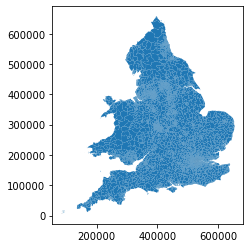

In [4]:
msoas = gpd.read_file( cache_data(spath+'Middle_Layer_Super_Output_Areas__December_2011__EW_BGC_V2-shp.zip?raw=true', ddir) )
msoas.plot();

In [5]:
msoas.sample(3)

,OBJECTID,MSOA11CD,MSOA11NM,MSOA11NMW,BNG_E,BNG_N,LONG,LAT,Shape__Are,Shape__Len,geometry
6884,6885,W02000098,Powys 002,Powys 002,324070,314553,-3.12566,52.72328,1.203275e+08,107305.027677,"POLYGON ((326897.687 322248.500, 326891.500 32..."
6755,6756,E02006898,Birmingham 137,Birmingham 137,405826,287125,-1.91563,52.48203,1.036278e+06,6791.670308,"POLYGON ((406064.958 287489.710, 405943.779 28..."
7060,7061,W02000281,Rhondda Cynon Taf 030,Rhondda Cynon Taf 030,304832,184157,-3.37389,51.54825,1.181972e+07,20869.906756,"POLYGON ((303266.187 186247.797, 303344.403 18..."


### Task 1.2: Select London MSOAs

#### 1.2.1. Union

As we don't have a boundary file for London, we can *generate* use using the `unary_union` operator (as we do here) or using the [dissolve()](https://geopandas.org/en/stable/docs/user_guide/aggregation_with_dissolve.html) approach. Consider the pros and cons of each approach in terms of performance, output format, and leigibility. 

So here's approach 1:

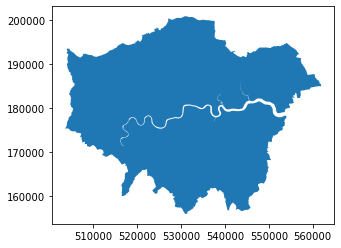

In [6]:
boros.dissolve().plot();

And here's approach 2:

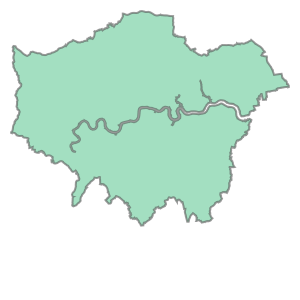

In [76]:
boros.unary_union

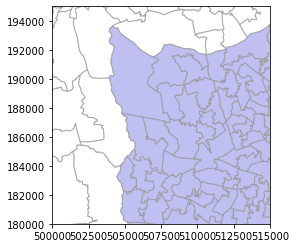

In [7]:
ldn = gpd.GeoDataFrame(gpd.GeoSeries(data=boros.unary_union)).rename(columns={0:'geometry'})
ldn = ldn.set_crs(epsg=27700)
ax  = ldn.plot(facecolor=(.5, .5, .9, .5));
msoas.plot(ax=ax, facecolor='none', edgecolor=(.6, .6, .6, .6))
ax.set_xlim(500000, 515000)
ax.set_ylim(180000, 195000);

#### 1.2.2. Buffer

In order to ensure that we get all MSOAs _within_ London we will buffer the boundary by 250m. If _cover_ were easier to use then that option might be preferable.

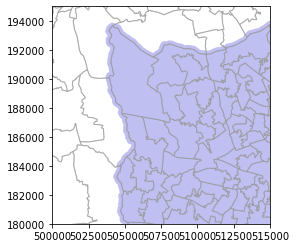

In [8]:
ldn['buffered'] = ldn.geometry.buffer(250)
ldn = ldn.set_geometry('buffered').set_crs(epsg=27700)
ax  = ldn.plot(facecolor=(.5, .5, .9, .5))
msoas.plot(ax=ax, facecolor='none', edgecolor=(.6, .6, .6, .6))
ax.set_xlim(500000, 515000)
ax.set_ylim(180000, 195000);

#### 1.2.3. Spatial Join

Here's our first spatial join. By default it will be an _inner_ join.

In [9]:
ldn_msoas = gpd.sjoin(msoas, ldn, predicate='???', how='inner')
ldn_msoas.head(2)

,OBJECTID,MSOA11CD,MSOA11NM,MSOA11NMW,BNG_E,BNG_N,LONG,LAT,Shape__Are,Shape__Len,geometry_left,index_right,geometry_right
0,1,E02000001,City of London 001,City of London 001,532384,181355,-0.093490,51.51561,2.906361e+06,8936.818478,"POLYGON ((532135.138 182198.131, 532158.250 18...",0,"POLYGON ((528150.200 159979.200, 528100.900 16..."
1,2,E02000002,Barking and Dagenham 001,Barking and Dagenham 001,548267,189685,0.138756,51.58652,2.166163e+06,8150.405928,"POLYGON ((548881.563 190845.265, 548881.125 19...",0,"POLYGON ((528150.200 159979.200, 528100.900 16..."


#### 1.2.4. Plot

<AxesSubplot:>

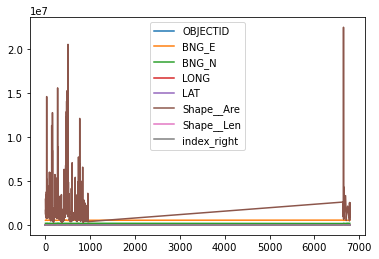

In [10]:
ldn_msoas.plot()

Hmmmm, not quite what you were expecting? See if you can figure out from the list of columns and the documentation for `set_geometry` what is going wrong?

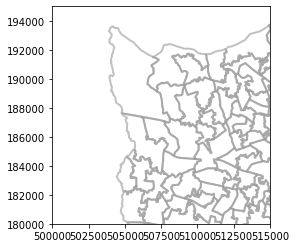

In [11]:
ax = ldn_msoas.set_geometry(???).plot(linewidth=2, facecolor='none', edgecolor=(.6, .6, .6, .6))
ax.set_xlim(500000, 515000)
ax.set_ylim(180000, 195000);

In [12]:
ldn_msoas = ldn_msoas.rename(columns={'geometry_left':'geometry'}).set_geometry('geometry')

In [13]:
ldn_msoas.drop(columns='geometry_right', inplace=True)

We no longer really need to keep the full MSOA data set hanging about.

In [14]:
try:
    del(msoas)
except NameError:
    print("msoas already deleted.")

#### 1.2.5. Questions

- Can you explain *why* the outputs of the `dissolve` and `unary_union` *look* differnet? And use that as the basis for explaining why they *are* different?
- How do you know that the units for the buffering operation are metres? 250 could be *anything* right?
- Why do we need to buffer the London geometry *before* performing the *within* spatial join?


### Task 1.3: Append Names

#### 1.3.1. Replace

You've done this before: notice that the MSOA Name _contains_ the Borough name. Use a regex (in `str.replace()`) to extract the LA name from the MSOA name. See if you do this *without* having to find your previous answer!

In [15]:
ldn_msoas['Borough'] = ldn_msoas.MSOA11NM.str.replace(???)

# Just check results look plausible; you should have:
# - 33 boroughs
# - A df shape of 983 x 13
print(ldn_msoas.Borough.unique())
print(f"There are {len(ldn_msoas.Borough.unique())} boroughs.")
print(f"Overall shape of data frame is {' x '.join([str(x) for x in ldn_msoas.shape])}")

['City of London' 'Barking and Dagenham' 'Barnet' 'Bexley' 'Brent'
 'Bromley' 'Camden' 'Croydon' 'Ealing' 'Enfield' 'Greenwich' 'Hackney'
 'Hammersmith and Fulham' 'Haringey' 'Harrow' 'Havering' 'Hillingdon'
 'Hounslow' 'Islington' 'Kensington and Chelsea' 'Kingston upon Thames'
 'Lambeth' 'Lewisham' 'Merton' 'Newham' 'Redbridge' 'Richmond upon Thames'
 'Southwark' 'Sutton' 'Tower Hamlets' 'Waltham Forest' 'Wandsworth'
 'Westminster']
There are 33 boroughs.
Overall shape of data frame is 983 x 13


#### 1.3.2. Merge

The House of Commons Library provides a [MSOA Names](https://houseofcommonslibrary.github.io/msoanames/) data set that contains locally-relevant names applied to MSOAs. These seek to connect the Census geography (OA > LSOA > MSOA > LA) to a loosely-defined 'neighbourhood'.

In [16]:
msoa_nms = pd.read_csv( cache_data('https://houseofcommonslibrary.github.io/msoanames/MSOA-Names-1.20.csv', ddir) )

Found data/geo/MSOA-Names-1.20.csv locally!


In [17]:
print(msoa_nms.columns.values)
msoa_nms.sample(3, random_state=42)

['msoa11cd' 'msoa11nm' 'msoa11nmw' 'msoa11hclnm' 'msoa11hclnmw' 'Laname']


,msoa11cd,msoa11nm,msoa11nmw,msoa11hclnm,msoa11hclnmw,Laname
4512,E02004616,Cotswold 002,Cotswold 002,Moreton & Stow-on-the-Wold,NaN,Cotswold
4660,E02004768,Havant 007,Havant 007,Waterlooville East,NaN,Havant
1038,E02001074,Manchester 030,Manchester 030,Fallowfield West & Whalley Range South,NaN,Manchester


Now that you've loaded the `msoa_nms` data you need to merge it with our `ldn_msoas`. You will need to deal with the fact that the left and right fields have different names and may also want to think about the `how` of the merge. In *this* case, the result of the merge *should* be a GeoDataFrame, but **this is not always guaranteed** so you may want to double-check or run multiple tests before assuming that you'll get back a geographically aware object.

In [18]:
msoas = pd.merge(ldn_msoas, msoa_nms, left_on=???, right_on=???, how=???)
print(f"MSOAs shape is {' x '.join([str(x) for x in msoas.shape])}.")
print(f"Resulting class is a {type(msoas).__name__}.") # You should check this -- result isn't always be a GeoDataFrame
msoas.sample(3, random_state=42)[['OBJECTID','MSOA11CD','MSOA11NM','msoa11hclnm']]

MSOAs shape is 983 x 19.
Resulting class is a GeoDataFrame.


,OBJECTID,MSOA11CD,MSOA11NM,msoa11hclnm
810,811,E02000841,Sutton 002,St Helier South
801,802,E02000832,Southwark 026,Nunhead North
813,814,E02000844,Sutton 005,The Wrythe


Your result should be:

|    | OBJECTID | MSOA11CD | MSOA11NM | msoa11hclnm |
| -: | -------: | -------: | :------- | :---------- |
| **810** | 811 | E02000841 | Sutton 002 | St Helier South |
| **801** | 802 | E02000832 | Southwark 026 | Nunhead North |
| **813** | 814 | E02000844 | Sutton 005 | The Wrythe |

#### 1.3.3. Map

Set up a `mapping` dict here so that you can apply it as part of the `groupby` operation below (you should have 33 keys when done):

In [19]:
mapping = {}
for b in ['Enfield','Waltham Forest','Redbridge','Barking and Dagenham','Havering','Greenwich','Bexley']:
    mapping[b]='Outer East and North East'
for b in ['Haringey','Islington','Hackney','Tower Hamlets','Newham','Lambeth','Southwark','Lewisham']:
    mapping[b]='Inner East'
for b in ['Bromley','Croydon','Sutton','Merton','Kingston upon Thames']:
    mapping[b]='Outer South'
for b in ['Wandsworth','Kensington and Chelsea','Hammersmith and Fulham','Westminster','Camden']:
    mapping[b]='Inner West'
for b in ['Richmond upon Thames','Hounslow','Ealing','Hillingdon','Brent','Harrow','Barnet','City of London']:
    mapping[b]='Outer West and North West'
print(len(mapping.keys()))

33


In [20]:
msoas['Subregion'] = msoas.Borough.???(???)

#### 1.3.3. Tidy Up

In [21]:
msoas.columns.to_list()

['OBJECTID',
 'MSOA11CD',
 'MSOA11NM',
 'MSOA11NMW',
 'BNG_E',
 'BNG_N',
 'LONG',
 'LAT',
 'Shape__Are',
 'Shape__Len',
 'geometry',
 'index_right',
 'Borough',
 'msoa11cd',
 'msoa11nm',
 'msoa11nmw',
 'msoa11hclnm',
 'msoa11hclnmw',
 'Laname',
 'Subregion']

In [22]:
to_drop = ['MSOA11CD','MSOA11NM','MSOA11NMW','LONG','LAT','Shape__Are','Shape__Len','index_right',
           'Laname','msoa11hclnmw','msoa11nmw']
msoas.drop(columns=to_drop, inplace=True)
print(msoas.shape)

(983, 9)


#### 1.3.4. And Save

In [23]:
msoas.to_file(os.path.join('data','geo','London_MSOA_Names.gpkg'), driver='GPKG')
msoas.to_feather(os.path.join('data','geo','London_MSOA_Names.geofeather'))

### Task 1.4: Load InsideAirbnb Data

In [24]:
host = 'http://orca.casa.ucl.ac.uk'
path = '~jreades/data'
listings = gpd.read_feather( cache_data(f'{host}/{path}/2022-09-10-listings.geofeather', ddir) )
listings = listings.to_crs(epsg=27700)
listings = listings.drop(columns=['index']).set_index('id')
print(f"Data frame is {listings.shape[0]:,} x {listings.shape[1]}")

Found data/geo/2022-09-10-listings.geofeather locally!
Data frame is 68,741 x 31


In [25]:
listings = listings.to_crs('epsg:27700')

#### 1.4.1. Spatial Join

Associate LA (Local Authority) names to the listings using a spatial join, but **notice** the `how` here:

In [26]:
gdf_la = gpd.sjoin(listings, boros, predicate='within', how='left')

In [27]:
print(gdf_la.columns.to_list())

['listing_url', 'last_scraped', 'name', 'description', 'host_id', 'host_name', 'host_since', 'host_location', 'host_is_superhost', 'host_listings_count', 'host_total_listings_count', 'host_verifications', 'latitude', 'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price', 'minimum_nights', 'maximum_nights', 'availability_365', 'number_of_reviews', 'first_review', 'last_review', 'review_scores_rating', 'reviews_per_month', 'geometry', 'index_right', 'NAME', 'GSS_CODE', 'HECTARES', 'NONLD_AREA', 'ONS_INNER']


#### 1.4.2. Tidy Up

In [28]:
gdf_la.drop(columns=['index_right','HECTARES','NONLD_AREA','ONS_INNER'], inplace=True)

You'll need to look closely to see what's wrong in the `value_counts` output, but here's a clue:

In [29]:
print(f"Now there are... {len(gdf_la.NAME.unique())} boroughs?")

Now there are... 34 boroughs?


In [30]:
gdf_la.NAME.value_counts(dropna=False)

Westminster               7694
Tower Hamlets             5518
Hackney                   5131
Camden                    4678
Kensington and Chelsea    4564
Southwark                 3941
Islington                 3766
Lambeth                   3695
Wandsworth                3449
Hammersmith and Fulham    2971
Brent                     2043
Lewisham                  2008
Haringey                  1879
Newham                    1640
Barnet                    1538
Ealing                    1534
Greenwich                 1477
Waltham Forest            1301
Merton                    1106
Croydon                   1028
Richmond upon Thames      1007
Hounslow                   991
NaN                        748
Redbridge                  628
Hillingdon                 605
Bromley                    568
Enfield                    567
Kingston upon Thames       561
Barking and Dagenham       420
City of London             417
Harrow                     403
Bexley                     321
Havering

In [31]:
gdf_la.columns

Index(['listing_url', 'last_scraped', 'name', 'description', 'host_id',
       'host_name', 'host_since', 'host_location', 'host_is_superhost',
       'host_listings_count', 'host_total_listings_count',
       'host_verifications', 'latitude', 'longitude', 'property_type',
       'room_type', 'accommodates', 'bathrooms_text', 'bedrooms', 'beds',
       'amenities', 'price', 'minimum_nights', 'maximum_nights',
       'availability_365', 'number_of_reviews', 'first_review', 'last_review',
       'review_scores_rating', 'reviews_per_month', 'geometry', 'NAME',
       'GSS_CODE'],
      dtype='object')

In [32]:
gdf_la[gdf_la.NAME.isna()].sample(5)[['name', 'NAME']]

,name,NAME
id,,
49845397,Character Beamed Barn Conversion,NaN
706976226554845952,"Semi rural, private suite, patio with hot-tub",NaN
32010725,A Beautiful Room with River Views. CENTRAL LONDON,NaN
53830002,Stunning 2 Bedroom house with parking,NaN
51001406,"Garland House, Dartford 4",NaN


#### 1.4.3. Find Problematic Listings

Let's map them and see if you can work out what happened...

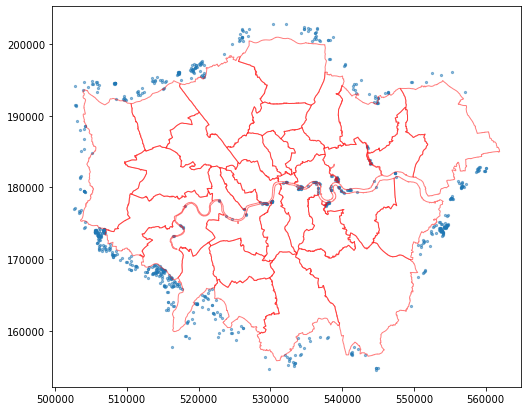

In [33]:
ax = gdf_la[gdf_la.NAME.???].plot(figsize=(10,7), markersize=5, alpha=0.5)
boros.plot(ax=ax, edgecolor='r', facecolor='None', alpha=0.5);

You should get something like: 

<img src="https://github.com/jreades/fsds/blob/master/practicals/img/Unmatched_Listings.png?raw=true" alt="Unmatched Listings" style="width:50%" />

#### 1.4.4. Drop Problematic Results

In [34]:
gdf_la.drop(index=gdf_la[gdf_la.NAME.isna()].index, axis=???, inplace=True)
print(f"Data frame is {gdf_la.shape[0]:,} x {gdf_la.shape[1]}")

Data frame is 67,993 x 33


You should now have 67,993 records.

#### 1.4.5. Check

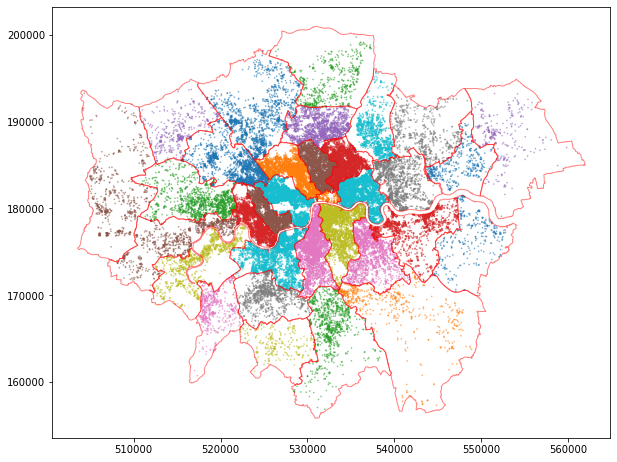

In [35]:
ax = gdf_la.plot(column='NAME', markersize=0.5, alpha=0.5, figsize=(10,8))
boros.plot(ax=ax, edgecolor='r', facecolor='None', alpha=0.5);

#### 1.4.6. Save

In [36]:
gdf_la.to_feather(os.path.join('data','geo','Listings_with_LA.geofeather'))

#### 1.4.7. Questions

- Do you understand the difference between `how='inner'` and `how='left'`?

### Task 1.5: Create LA Data

#### 1.5.1. Select LA

Select a LA that is relevant to _you_ to explore further...

In [37]:
LA = 'Waltham Forest'

#### 1.5.2. Spatial Join

The first thing we want to do is join MSOA identifiers to each listing. In both cases we want to constrain the data to only be for 'our' LA of interest: 

In [38]:
msoadf  = gpd.sjoin(
            gdf_la[???==LA].reset_index(), 
            msoas[???==LA], predicate='within')

#### 1.5.3. Aggregate

Now aggregate the data by MSOA, deriving median price and a count of the listings:

In [39]:
msoagrdf = msoadf.groupby('msoa11nm').agg({'price':['median','count']}).reset_index()

In [40]:
msoagrdf.sample(3, random_state=42)

msoa11nm  price      
                       median count
9   Waltham Forest 010   55.0    25
25  Waltham Forest 026   75.0    72
8   Waltham Forest 009   51.5    26

You should get something like the below (if you're using Waltham Forest):

|   | msoa11nm |  | price |
| -: | ------: | ----: | ----: |
|   | **median** | **count** |
| 9 | Waltham Forest 010 | 55.0 | 25 |
| 25 | Waltham Forest 026 | 75.0 | 72 |
| 8 | Waltham Forest 009 | 51.5 | 26 |

#### 1.5.4. Resolve Columns

Which level value is easier to use? 0? or 1?

In [41]:
msoagrdf.columns = msoagrdf.columns.get_level_values(1)
msoagrdf.head()

,,median,count
0,Waltham Forest 001,98.5,20
1,Waltham Forest 002,56.0,9
2,Waltham Forest 003,80.0,4
3,Waltham Forest 004,45.0,7
4,Waltham Forest 005,50.0,13


Fix the missing column name:

In [42]:
msoagrdf.rename(columns={'':'msoa11nm', 'count':'listings'}, inplace=True)
msoagrdf.head()

,msoa11nm,median,listings
0,Waltham Forest 001,98.5,20
1,Waltham Forest 002,56.0,9
2,Waltham Forest 003,80.0,4
3,Waltham Forest 004,45.0,7
4,Waltham Forest 005,50.0,13


#### 1.5.5. Join (Again)

Here we see the **difference between merge and join**. You'll notice that `join` operates by taking one data frame as the implicit '*left*' table (the one which *calls* join) while the one that is passed to the join function is, implicitly, the '*right*' table. Join operates only using indexes, so you'll need to insert the code to specify the same index on both data frames, but this can be done **on-the-fly** as part of the joining operation:

In [43]:
msoa_gdf = msoagrdf.set_index('msoa11nm').join(
                msoas[msoas.Borough==LA].set_index('msoa11nm'), 
                rsuffix='_r')
msoa_gdf.head(3)

,median,listings,OBJECTID,BNG_E,BNG_N,geometry,Borough,msoa11cd,msoa11hclnm,Subregion
msoa11nm,,,,,,,,,,
Waltham Forest 001,98.5,20,863,537936,194880,"POLYGON ((537919.442 195742.428, 538051.250 19...",Waltham Forest,E02000895,Chingford Green West,Outer East and North East
Waltham Forest 002,56.0,9,864,539350,194516,"POLYGON ((539172.688 195540.000, 539696.813 19...",Waltham Forest,E02000896,Chingford Green East,Outer East and North East
Waltham Forest 003,80.0,4,865,539355,193522,"POLYGON ((538862.624 194017.438, 539001.125 19...",Waltham Forest,E02000897,Friday Hill,Outer East and North East


#### 1.5.6. Resolve Geodata

You need to add a command in order to help python recognise that this should be a GeoDataFrame:

In [44]:
msoa_gdf = msoa_gdf.???

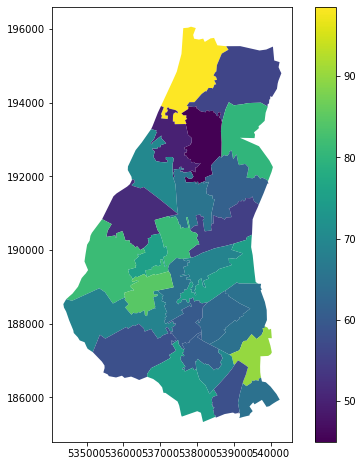

In [45]:
msoa_gdf.plot(column='median', legend=True, figsize=(8,8));

#### 1.5.7. Save

Just so that we can pick up here without having to re-run all the preceding cells.

In [46]:
msoa_gdf.to_feather(os.path.join('data','geo',f'{LA}-MSOA_data.geofeather'))

#### 1.5.8. Questions

- Do you understand the differences between `pd.merge` and `df.join`? and `gpd.sjoin`?
- Do you understand why it may be necessary to `set_geometry` in some cases?

## Task 2. Using Maplotlib

### Task 2.1: Anatomy of a Figure

*One* of the reasons that Matplotlib is so much more complex than `ggplot` is that it can actually *do* a plot more than ggplot, including image manipulation, axis translation, and even 3D. You can get a sense of this by looking at [the tutorials](https://matplotlib.org/stable/tutorials/index.html) since the [Users guide](https://matplotlib.org/stable/users/index.html) can be a bit overwhelming.

Nevertheless, the [core components of all matplotlib figures](https://matplotlib.org/stable/gallery/showcase/anatomy.html) can be seen here:

<img src="https://matplotlib.org/stable/_images/sphx_glr_anatomy_001.png" alt="Anatomy of a Figure" style="width:50%" />

### Task 2.2: Finding Fonts

I find matplotlib's use of fonts to be _profoundly_ weird. If you use `conda` and install directly on to the computer then you _might_ have access to all of your computer's fonts (though there are different *types* of fonts as well, not all of which will show up), but for most users it will be those that were installed into Docker. 

#### 2.2.1. Using Fontconfig

`fontconfig` is the base Linux utility for managing fonts. We can list font using `fc-list` and then a set of 'switches' determining the kind of information we want back. Since fontconfig doesn't exist on OSX or Windows, you'll need to do some more investigating and poking around to get these details on a `conda` install (I'll show an option further down)...

<div class="alert alert-block alert-success">
    <b>&#128161; Tip</b>: notice that below we're able to capture the output of an external application (called via the Terminal) with <tt>fonts = ! ...</tt>. This can be useful when something is easy to do on the command line but hard to do in Python.
</div>

Here we ask fontconfig to format the output so that we only get the first part of the family name, and then we pipe (recall `|` sends output from one utility to another!) the output of that to `sort`, which sorts the output, and `uniq` which removes duplicates (which there will be because there are **bold**, *italic*, small-caps, etc. versions of each font). To make better sense of this you can always try playing around with all three steps in the output below!

In [47]:
fonts = ! fc-list --format="%{family[0]}\n" | sort | uniq
print(fonts)

['Bitstream Charter', 'C059', 'Courier', 'D050000L', 'DejaVu Sans', 'Inconsolata', 'JetBrains Mono', 'LMMono10', 'LMMonoCaps10', 'LMMonoLt10', 'LMMonoLtCond10', 'LMMonoProp10', 'LMMonoPropLt10', 'LMMonoSlant10', 'LMRoman10', 'LMRomanCaps10', 'LMRomanDemi10', 'LMRomanDunh10', 'LMRomanSlant10', 'LMRomanUnsl10', 'LMSans10', 'LMSansDemiCond10', 'LMSansQuot8', 'Liberation Mono', 'Liberation Sans', 'Liberation Sans Narrow', 'Liberation Serif', 'Nimbus Mono PS', 'Nimbus Roman', 'Nimbus Sans', 'Nimbus Sans Narrow', 'P052', 'Roboto', 'Source Code Pro', 'Spectral', 'Spectral SC', 'Standard Symbols PS', 'URW Bookman', 'URW Gothic', 'Ubuntu', 'Ubuntu Condensed', 'Ubuntu Mono', 'Utopia', 'Z003']


This also pipes output from fonctconfig, but to the `grep` utility which checks each line for the character sequence `Liberation`. Now we're asking fontconfig to include `style` details which will relate to both weight (regular, bold, extra bold, light, etc.) and italic, bold, small caps, etc.

In [48]:
fonts = ! fc-list : family style | grep "Liberation"
print(sorted(fonts))

['Liberation Mono:style=Bold', 'Liberation Mono:style=Bold Italic', 'Liberation Mono:style=Italic', 'Liberation Mono:style=Regular', 'Liberation Sans Narrow:style=Bold', 'Liberation Sans Narrow:style=Bold Italic', 'Liberation Sans Narrow:style=Italic', 'Liberation Sans Narrow:style=Regular', 'Liberation Sans:style=Bold', 'Liberation Sans:style=Bold Italic', 'Liberation Sans:style=Italic', 'Liberation Sans:style=Regular', 'Liberation Serif:style=Bold', 'Liberation Serif:style=Bold Italic', 'Liberation Serif:style=Italic', 'Liberation Serif:style=Regular']


You can find more examples [here](https://www.geeksforgeeks.org/fc-list-command-in-linux-with-examples/), a more detailed set of instructions [here](https://www.freedesktop.org/software/fontconfig/fontconfig-user.html), and even information about (for example) [supported languages](https://thottingal.in/blog/2016/03/04/fontconfig-language-matching/) based on [RFC 3066](http://www.i18nguy.com/unicode/language-identifiers.html).

Here are the languages supported by the Ubuntu Light font:

In [49]:
! fc-list "Ubuntu Light" : lang

:lang=aa|ab|af|av|ay|ba|be|bg|bi|br|bs|bua|ca|ce|ch|chm|co|cs|cv|cy|da|de|el|en|eo|es|et|eu|fi|fj|fo|fr|fur|fy|gd|gl|gv|ho|hr|hu|ia|id|ie|ik|io|is|it|kaa|ki|kk|kl|kum|kv|kw|ky|la|lb|lez|lt|lv|mg|mh|mk|mo|mt|nb|nds|nl|nn|no|nr|nso|ny|oc|om|os|pl|pt|rm|ro|ru|sah|sco|se|sel|sh|sk|sl|sma|smj|smn|sms|so|sq|sr|ss|st|sv|sw|tg|tk|tl|tn|tr|ts|tt|tyv|uk|uz|vo|vot|wa|wen|wo|xh|yap|zu|an|crh|csb|fil|hsb|ht|jv|kj|kr|ku-tr|kwm|lg|li|mn-mn|ms|na|ng|pap-an|pap-aw|rn|rw|sc|sg|sn|su|ty|za


Here are the monospace fonts installed: 

In [50]:
! fc-list :spacing=mono : family | sort | uniq

Courier
Inconsolata
Liberation Mono
Nimbus Mono PS
Source Code Pro
Source Code Pro,Source Code Pro Black
Source Code Pro,Source Code Pro ExtraLight
Source Code Pro,Source Code Pro Light
Source Code Pro,Source Code Pro Medium
Source Code Pro,Source Code Pro Semibold
Ubuntu Mono


#### 2.2.2. Using Python+Terminal

Another way to get at this information is to try asking matplotlib what fonts it *already* knows about in its cache:

In [51]:
import matplotlib
loc = matplotlib.get_cachedir()
!ls {loc}

fontlist-v330.json


Hopefully you will see a list of installed fonts when you run this next block of code. See if you can make sense of what this code does!

In [52]:
fonts = !cat {loc + '/fontlist-v330.json'}
fonts = set(list(filter(lambda x:'"name"' in x, fonts)))
fonts = [x.replace('      "name": "','').replace('",','') for x in fonts]
print(fonts)

['STIXSizeTwoSym', 'Latin Modern Math', 'cmsy10', 'DejaVu Serif', 'Latin Modern Roman Unslanted', 'Nimbus Sans', 'Helvetica', 'Latin Modern Roman Demi', 'Bitstream Charter', 'Computer Modern', 'URW Gothic', 'STIXNonUnicode', 'Liberation Sans', 'Latin Modern Roman Slanted', 'STIXGeneral', 'Liberation Mono', 'Latin Modern Mono Prop', 'Utopia', 'Times', 'STIXSizeOneSym', 'Standard Symbols PS', 'New Century Schoolbook', 'Latin Modern Mono Prop Light', 'Liberation Sans Narrow', 'Latin Modern Mono Light', 'DejaVu Sans Mono', 'Symbol', 'DejaVu Serif Display', 'ZapfDingbats', 'STIXSizeFourSym', 'ITC Avant Garde Gothic', 'Z003', 'cmex10', 'Nimbus Roman', 'Latin Modern Sans Quotation', 'Latin Modern Mono Light Cond', 'URW Bookman', 'cmss10', 'Nimbus Sans Narrow', 'P052', 'cmb10', 'DejaVu Sans', 'STIXSizeFiveSym', 'Latin Modern Sans', 'ITC Bookman', 'D050000L', 'cmr10', 'Latin Modern Roman', 'Latin Modern Mono Slanted', 'Latin Modern Roman Dunhill', 'Latin Modern Mono Caps', 'Nimbus Mono PS', 'La

In [53]:
fonts = ! fc-list : family style | grep "Ubuntu"
print(sorted(fonts))

['Ubuntu Condensed:style=Regular', 'Ubuntu Mono:style=Bold', 'Ubuntu Mono:style=Bold Italic', 'Ubuntu Mono:style=Italic', 'Ubuntu Mono:style=Regular', 'Ubuntu,Ubuntu Light:style=Light Italic,Italic', 'Ubuntu,Ubuntu Light:style=Light,Regular', 'Ubuntu,Ubuntu Light:style=Medium Italic,Bold Italic', 'Ubuntu,Ubuntu Light:style=Medium,Bold', 'Ubuntu,Ubuntu Thin:style=Thin,Regular', 'Ubuntu:style=Bold', 'Ubuntu:style=Bold Italic', 'Ubuntu:style=Italic', 'Ubuntu:style=Regular']


#### 2.2.3. Fontdicts

Now that we know what's available, the next step is to set up some useful defaults that we can re-use across multiple plots to ensure consistency of output. The format for specifying fonts on a per-figure basis is a dictionary, so where you see `fontdict` in the `matplotlib` [documentation](https://matplotlib.org/stable/gallery/text_labels_and_annotations/text_fontdict.html) the following should work:

Here's the example:

```python
font = {'family': 'serif',
        'color':  'darkred',
        'weight': 'normal',
        'size': 16,
        }
```

In [54]:
tfont = {'fontname':'Liberation Sans Narrow', 'weight':'bold'}
bfont = {'fontname':'Liberation Sans Narrow', 'weight':'normal', 'horizontalalignment':'left'}
afont = {'fontname':'Liberation Sans Narrow', 'weight':'light'}

I am setting the 'title font' (`tfont`) and 'body copy font' (`bfont`) and 'axis font' (`afont`) here to use in the output below. You can pick another font and see what happens. 

### 2.3: Using Fonts

In [55]:
LA = 'Waltham Forest'

In [56]:
msoa_gdf = gpd.read_feather(os.path.join('data','geo',f'{LA}-MSOA_data.geofeather'))

In [57]:
median_gdf  = msoa_gdf[['msoa11cd','median','geometry']]
listing_gdf = msoa_gdf[['msoa11cd','listings','geometry']].rename(columns={'listings':'count'})

In [58]:
import matplotlib.pyplot as plt

#### 2.3.1. The Defaults

Here is a demonstration of some of the ways you can adjust features in a Python matplotlib plot. I'm not suggesting either of these is a _good_ output, but that's not the point! The idea is to see the various ways you can tweak a plot...

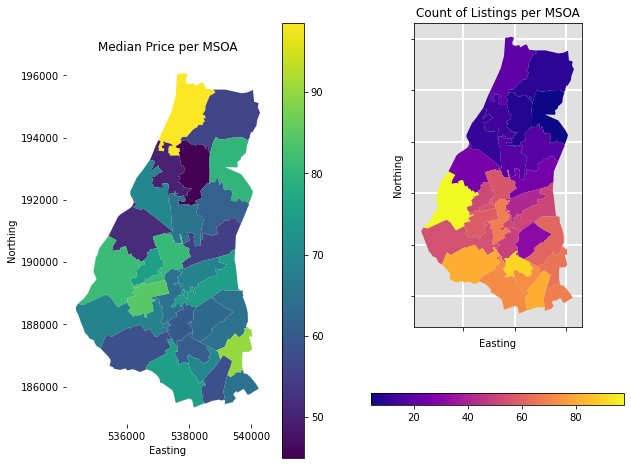

In [59]:
# Set up a 1 x 2 plot (you can also leave off the nrows= and ncols=)
f,axes = plt.subplots(nrows=1, ncols=2, figsize=(10,8))
# ax1 will be the first plot on the left, ax2 will be on the right;
# a 2 (or more) *row* plot will return a list of lists... 1 list/row.
ax1 = axes[0]
ax2 = axes[1]

# Left plot is the median price
median_gdf.plot(column='median', ax=ax1, legend=True, cmap='viridis')
ax1.set_title("Median Price per MSOA");
# Turn off the frame, one side of the plat at a time
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.spines['left'].set_visible(False)
# Set the labels
ax1.set_xlabel("Easting");
ax1.set_ylabel("Northing");

# Right plot is the number of listings; note
# here the use of both zorder (which is the 
# 'stacking order' of elements on the plot, and
# the legend_kwds (keywords) to change the 
# orientation of the plot to horizontal
listing_gdf.plot(column='count', ax=ax2, legend=True, cmap='plasma', zorder=1, 
                 legend_kwds={"orientation": "horizontal"})
ax2.set_title("Count of Listings per MSOA");
# Set a background colour for the plot
ax2.set_facecolor((.4, .4, .4, .2))
# Add grid lines and set their zorder to
# below that of the data on the plot
plt.grid(visible=True, which='major', axis='both', color='w', linestyle='-', linewidth=2, zorder=0)
ax2.set_axisbelow(True)

# This is equivalent to the ax1.spines... 
# above, but if you use it here you lose
# the background to the plot as well!
#plt.gca().set(frame_on=False)

# Remove the labels on the ticks of the 
# axes (meaning: remove the numbers on 
# x- and y-axes).
ax2.set_xticklabels([])
ax2.set_yticklabels([])

# Set the labels
ax2.set_xlabel("Easting");
ax2.set_ylabel("Northing");

#### 2.3.2: Improving on Defaults

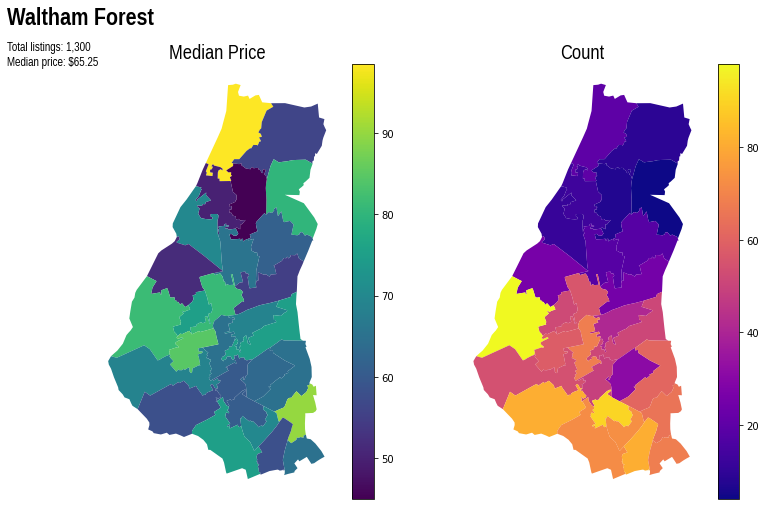

In [60]:
f,axes = plt.subplots(1,2,figsize=(12,8))

# Set up the plots
median_gdf.plot(column='median', ax=axes[0], legend=True, cmap='viridis')
listing_gdf.plot(column='count', ax=axes[1], legend=True, cmap='plasma')
for ax in axes:
    ax.axis('off')
    # Note that here, set_facebolor doesn't work,
    # presumably because the axis is 'off'
    ax.set_facecolor((.4, .4, .4, .2))

# Add the 'super-title', but notice that it is not 
# longer either centered (x=0.025) or centre-aligned
# (horizonal alignment=left). We also see **tfont, which
# is a way of expading the 'tfont' dictionary into a 
# set of parameters to a function call. We do the same
# for the titles on each figure, but passing a different
# fontdict.
f.suptitle(LA, x=0.025, ha='left', size=24, **tfont)
axes[0].set_title('Median Price', size=20, **afont)
axes[1].set_title('Count', size=20, **afont)

# And add a short piece of text below the borough
plt.figtext(x=0.025, y=0.92, linespacing=1.4, va='top', size=12, 
            s=f"Total listings: {listing_gdf['count'].sum():,.0f}\nMedian price: ${median_gdf['median'].median():,.2f}", **bfont);

## Task 3. Create an Atlas

### Task 3.1: Adding Picture-in-Picture 

We're now going to emulate a _bit_ of QGIS' Atlas function by creating two subplots and then adding a _third_ plot afterwards that shows where the borough is.

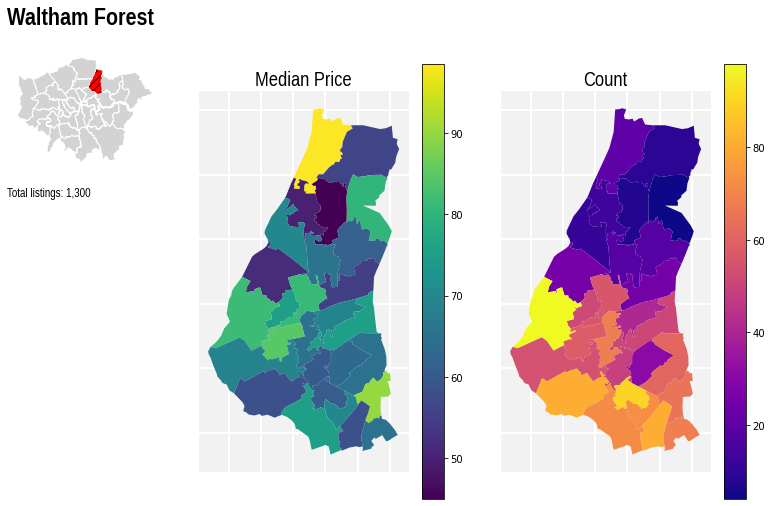

In [61]:
f,axes = plt.subplots(1,3,gridspec_kw={'width_ratios':[1,4,4]}, figsize=(12,8))

# Plot 0 is basically being used as a 'spacer' 
# as you'll see below
axes[0].axis('off')

# Plot 1 is the median price
median_gdf.plot(column='median', ax=axes[1], legend=True, cmap='viridis')
axes[1].set_title('Median Price', size=20, **afont)

# Plot 2 is the count of listings
listing_gdf.plot(column='count', ax=axes[2], legend=True, cmap='plasma')
axes[2].set_title('Count', size=20, **afont)

# For plots 1 and 2...
for ax in axes[1:]:
    ax.set_facecolor((.9, .9, .9, .5))
    ax.grid(visible=True, which='major', axis='both', color='w', linestyle='-', linewidth=2, zorder=0)
    ax.set_axisbelow(True)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.tick_params(axis='both', which='both', length=0)

# Add a *third* chart that we use as a kind of 'PiP'
# to show which borough we're talking about. The 
# add_axes call is here taking information about the
# positioning and size of the additional figure.
# Disable ax2.axis('off') if you want to see the
# figure in full.
ax3 = f.add_axes([0.015, 0.7, 0.2, 0.2])
boros.plot(facecolor='lightgrey', edgecolor='w', linewidth=1, ax=ax3)
boros[boros.NAME==LA].plot(facecolor='r', edgecolor='none', hatch='///', ax=ax3)
ax3.axis('off')

# Add the 'super-title', but notice that it is not 
# longer either centered (x=0.025) or centre-aligned
# (horizonal alignment=left). We also see **tfont, which
# is a way of expading the 'tfont' dictionary into a 
# set of parameters to a function call. We do the same
# for the titles on each figure, but passing a different
# fontdict.
f.suptitle(LA, x=0.025, ha='left', size=24, **tfont)

# And add a short piece of text below the borough
plt.figtext(x=0.025, y=0.65, s=f"Total listings: {listing_gdf['count'].sum():,.0f}", size=12, **bfont);

### Task 3.2: Bonus Achievement Unlocked!

If you have the time and inclination, see if you can convert the above to an _actual_ atlas output: 

1. You'll want to turn this plot into a function so as to be able to produce (and save) the map for _every_ borough. 
2. You'll even need to parameterise the filename so that you save to _different_ PNG files as well as going back to see how we generated the listing and pricing data frames for the Local Authority... 
3. And you'll *also* need to make sure that you ensure a consistent colour bar (for all of London, because the median price and number of listings will vary rather a lot by LA)
4. Then there's the placement of the PiP for some boroughs with long names
5. And finally, you might consider adding some more text to atlas--maybe pull some content from Wikipedia using Beautiful Soup (`bs4`)?

## Task 4. Think Text!

I also wanted to draw your attention to this [outstanding piece](https://blog.datawrapper.de/text-in-data-visualizations/) on using text effectively in data visualisation: we often add labels as afterthoughts without too much regard for where they go or how they look; however, getting the content, positioning, size, and even font/font-weight 'right' can make all the difference to the effectiveness of your chart! The illustrations are top-notch, but here are the takeaways:

Show information where readers need it:

<img src="https://blog.datawrapper.de/wp-content/uploads/2022/08/copy-25-2-1024x435.png" alt="" style="width:50%;" />

Make the units obvious:

<img src="https://blog.datawrapper.de/wp-content/uploads/2022/08/Artboard-1-copy-150-2-1024x435.png" alt="" style="width:50%;" />

Use tooltips effectively (where relevant):

<img src="https://blog.datawrapper.de/wp-content/uploads/2022/08/Artboard-1-copy-148-1024x435.png" alt="" style="width:50%;" />

Put tickmarks where they're needed:

<img src="https://blog.datawrapper.de/wp-content/uploads/2022/08/copy-29-1-1024x435.png" alt="" style="width:50%;" />

Annotate for emphasis and explanation:

<img src="https://blog.datawrapper.de/wp-content/uploads/2022/08/rule2-copy-16-1024x436.png" alt="" style="width:50%;" />

Pick a font for legibility:

<img src="https://blog.datawrapper.de/wp-content/uploads/2022/08/Artboard-1-copy-161-1024x869.png" alt="" style="width:50%;" />

Use font, colour and style to lead the eye:

<img src="https://blog.datawrapper.de/wp-content/uploads/2022/08/Artboard-1-copy-193-1024x728.png" alt="" style="width:50%;" />

Use one font well:

<img src="https://blog.datawrapper.de/wp-content/uploads/2022/08/Artboard-1-copy-155-1024x454.png" alt="" style="width:50%;" />

For the sake of all that is holy, don't centre-align:

<img src="https://blog.datawrapper.de/wp-content/uploads/2022/08/Artboard-1-copy-156-1024x493.png" alt="" style="width:50%;" />

Don't rotate heads:

<img src="https://blog.datawrapper.de/wp-content/uploads/2022/08/Artboard-1-copy-147-1-1024x435.png" alt="" style="width:50%;" />

And see this:

<img src="https://blog.datawrapper.de/wp-content/uploads/2022/08/Artboard-1-copy-152-2-1024x435.png" alt="" style="width:50%;" />

Use outlines effectively:

<img src="https://blog.datawrapper.de/wp-content/uploads/2022/08/Artboard-1-copy-194-1024x454.png" alt="" style="width:50%;" />

Phrase for readability:

<img src="https://blog.datawrapper.de/wp-content/uploads/2022/09/Artboard-1-copy-163-1024x482.png" alt="" style="width:50%;" />

Conversation first, precision later:

<img src="https://blog.datawrapper.de/wp-content/uploads/2022/08/Artboard-1-copy-164-2-1024x422.png" alt="" style="width:50%;" />

Use appropriate precision:

<img src="https://blog.datawrapper.de/wp-content/uploads/2022/08/Artboard-1-copy-162-1-1024x414.png" alt="" style="width:50%;" />

And see the bibliography at the end!

<div class="alert alert-block alert-success">
    <b>&#128161; Tip</b>: Basically, bookmark this blog post and refer to it every time you are making a map or chart.
</div>

## Task 5. Using Bokeh

In [62]:
LA = 'Camden'

In [63]:
gdf_la = gpd.read_feather(os.path.join('data','geo','Listings_with_LA.geofeather'))
msoas  = gpd.read_feather(os.path.join('data','geo','London_MSOA_Names.geofeather'))

### Task 5.1: For a Chart

Group the listings by Borough and Room Type, and aggregate by median price, also producing a count variable for the number of listings of each type in each Borough.

In [64]:
la_tots = gdf_la[gdf_la.NAME==LA].groupby(by='room_type').agg(
                            {'price':'median', 'listing_url':'count'}
                        ).reset_index().rename(columns={'listing_url':'count'})
la_tots

,room_type,price,count
0,Entire home/apt,159.0,3132
1,Hotel room,179.0,16
2,Private room,65.0,1499
3,Shared room,39.0,31


In [67]:
from bokeh.io import output_notebook, show
from bokeh.plotting import figure
from bokeh.models import ColumnDataSource, HoverTool
from bokeh.palettes import Spectral4
from bokeh.models import CustomJS, Dropdown

output_notebook()

room_types = la_tots.room_type.to_list()
prices     = la_tots.price.to_list()
counts     = la_tots['count'].to_list()

# Add hover tooltip
source = ColumnDataSource(data=dict(
    rt=room_types,
    count=counts,
    price=prices,
))

TOOLTIPS = [
    ("Room Type", "@rt"),
    ("Number of Listings", "@count{,}"),
    ("Median Price", "$@price{,}/night")
]

p = figure(x_range=room_types, height=300, tooltips=TOOLTIPS,
           title=f"Median Price by Room Type in {LA}",
           toolbar_location=None, tools="")

p.vbar(x='rt', top='count', width=0.9, source=source)
p.xgrid.grid_line_color = None
p.y_range.start = 0

show(p)

Loading BokehJS ...

### Task 5.2: For a Map

This is not the prettiest code, but it should work...

In [68]:
from bokeh.plotting import figure
from bokeh.tile_providers import CARTODBPOSITRON, get_provider

from bokeh.io import output_file, show, output_notebook, push_notebook, export_png
from bokeh.models import ColumnDataSource, GeoJSONDataSource, LinearColorMapper, ColorBar, HoverTool
from bokeh.plotting import figure
from bokeh.palettes import brewer

output_notebook()

Loading BokehJS ...

In [69]:
msoadf = gpd.sjoin(
            gdf_la[gdf_la.NAME==LA].reset_index(), 
            msoas[msoas.Borough==LA], predicate='within')

In [70]:
msoagrdf = msoadf.groupby('msoa11nm').agg({'price':['median','count']}).reset_index()
msoagrdf.columns=['msoa11nm','median','count']

I cobbled the mapping functions below together from two tutorials I found online ([this one](https://github.com/dmnfarrell/teaching/blob/master/geo/maps_python.ipynb) and [this one](https://widdowquinn.github.io/Teaching-Data-Visualisation/exercises/interactive_bokeh_map/interactive_bokeh_map.html)). As you can see, this is a very different approach to mapping data, but it has clear benefits for exploratory purposes and produces fast, interactive maps... and I've not even added selection and filtering tools!

In [71]:
def get_geodatasource(gdf):    
    """Get getjsondatasource from geopandas object"""
    json_data = json.dumps(json.loads(gdf.to_json()))
    return GeoJSONDataSource(geojson = json_data)

def bokeh_plot_map(gdf, column=None, title=''):
    """Plot bokeh map from GeoJSONDataSource """
    
    tile_provider = get_provider(CARTODBPOSITRON)

    geosource = get_geodatasource(gdf)
    palette = brewer['OrRd'][8]
    palette = palette[::-1]
    vals = gdf[column]
    
    #Instantiate LinearColorMapper that linearly maps numbers in a range, into a sequence of colors.
    color_mapper = LinearColorMapper(palette=palette, low=vals.min(), high=vals.max())
    color_bar = ColorBar(color_mapper=color_mapper, label_standoff=8, width=500, height=10,
                         location=(0,0), orientation='horizontal')

    tools = 'wheel_zoom,pan,reset,hover'
    
    p = figure(title = title, plot_height=700, plot_width=850, toolbar_location='right', tools=tools)
    p.add_tile(tile_provider)
    p.xgrid.grid_line_color = None
    p.ygrid.grid_line_color = None
    
    # Add patch renderer to figure
    p.patches('xs','ys', source=geosource, fill_alpha=0.5, line_width=0.5, line_color='white',  
              fill_color={'field' :column , 'transform': color_mapper})
    
    # Specify figure layout.
    p.add_layout(color_bar, 'below')
    
    # Add hover
    hover = p.select_one(HoverTool)
    hover.point_policy = "follow_mouse"
    hover.tooltips = [("Borough", "@Borough"),
                      ("Neighbourhood", "@msoa11hclnm"),
                      ("Count of Listings", "@count"),
                      ("Median Price", "$@median")]
    
    return p

Reproject to Web Mercator:

In [72]:
msoa_gdf = pd.merge(msoagrdf, msoas, left_on='msoa11nm', right_on='msoa11nm', how='inner')
msoa_gdf = msoa_gdf.set_geometry('geometry').set_crs('epsg:27700')

In [73]:
msoageo = msoa_gdf.to_crs('epsg:3785')
msoageo.total_bounds

array([ -23584.5942078 , 6712392.186146  ,  -11547.90024395,
       6723189.72863503])

And map it!

In [74]:
p = bokeh_plot_map(msoageo, 'median', title=f'MSOA-Level Activity in {LA}')

handle = show(p, notebook_handle=True)
push_notebook(handle=handle)